In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [2]:
#Configure TensorFlow to use GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])

print(tf.__version__)

2.9.1


In [3]:
DATADIR = 'E:/Datasets/planes'

image_size = 64
latent_dim = 100

X = []

# load real samples
for img in os.listdir(DATADIR):
    path = os.path.join(DATADIR, img)
    img = cv2.imread(path)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    X.append(img)

In [4]:
X = np.array(X, dtype='float32')
print(X.shape)

(9971, 64, 64, 3)


(64, 64, 3)


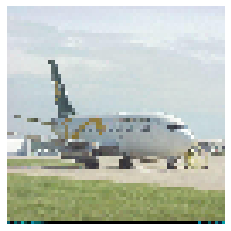

In [5]:
# show sample image
sample_img = X[0]
print(sample_img.shape)
plt.axis('off')
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.savefig('images/sample.png')
plt.show()

In [6]:
#seeds for progress images
generated_images = 16 #must be square
seed = np.random.randn(latent_dim * generated_images).astype(np.float32)
seed = seed.reshape(generated_images, latent_dim)

In [7]:
def discriminator(in_shape=(image_size, image_size, 3)):

    model = Sequential()

    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 32x32
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 16x16
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 8x8
    model.add(Conv2D(128, (5,5), strides=(4,4), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample to 4x4
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model

In [8]:
d = discriminator()

In [9]:
d.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       409728    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 128)         4

In [10]:
def generator(lat_dim):

	model = Sequential()

	# 4x4
	n_nodes = 128 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 128)))

	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# upsample to 64x64
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))

	# output layer 64x64x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))

	return model

In [11]:
g = generator(latent_dim)

In [12]:
g.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              206848    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [13]:
def gan(gen, discrim):

       discrim.trainable = False

       model = Sequential()
       model.add(gen)
       model.add(discrim)

       opt = Adam(learning_rate=0.0002, beta_1=0.5)
       model.compile(loss='binary_crossentropy', optimizer=opt)

       return model

In [14]:
gan = gan(g, d)

In [15]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 64, 64, 3)         1265539   
                                                                 
 sequential (Sequential)     (None, 1)                 1649153   
                                                                 
Total params: 2,914,692
Trainable params: 1,265,539
Non-trainable params: 1,649,153
_________________________________________________________________


In [16]:
def generate_latent_points(lat_dim, n_samples):

    assert lat_dim > 0 and n_samples > 0

    x_input = np.random.randn(lat_dim * n_samples)
    x_input = x_input.reshape(n_samples, lat_dim)

    return x_input

In [17]:
def generate_fake_samples(gen, lat_dim, n_samples, seeds=None):

   if seeds is None:
       x_input = generate_latent_points(lat_dim, int(n_samples))
   else:
       x_input = seeds

   x_fake = gen.predict(x_input, verbose=0)

   #0 = fake sample
   y_fake = np.zeros((int(n_samples), 1))

   return x_fake, y_fake

In [18]:
def get_real_samples(n_samples):

       ix = np.random.randint(0, X.shape[0], int(n_samples))

       x_real = X[ix]

       x_real.reshape(n_samples, image_size, image_size, 3)

       #1 = real sample
       y_real = np.ones((int(n_samples), 1))

       return x_real, y_real

In [19]:
def generate_and_save_images(gen, epoch):

       #produces a square of n x n images
       n = int(np.sqrt(generated_images))

       x_fake, _ = generate_fake_samples(gen, latent_dim, generated_images, seed)

       x_fake = x_fake.reshape((n*n, image_size, image_size, 3))

       for im in range(n*n):
           plt.subplot(n, n, 1 + im)
           plt.axis('off')
           plt.imshow(np.clip(cv2.cvtColor(x_fake[im], cv2.COLOR_BGR2RGB), 0, 1))

       plt.savefig(f'images/epoch_{epoch + 1}.png')
       #plt.show()

In [20]:
g_losses = []
d_losses = []
g_acc = []
d_acc = []

In [21]:
def test_accuracy(gen, discrim, n_tests=100):

       x_real, y_real = get_real_samples(n_tests)

       x_fake, y_fake = generate_fake_samples(gen, latent_dim, n_tests)

       _, acc_real = discrim.evaluate(x_real, y_real, verbose=0)

       _, acc_fake = discrim.evaluate(x_fake, y_fake, verbose=0)

       print(f'Accuracy real: {acc_real * 100:.2f}%')
       print(f'Accuracy fake: {acc_fake * 100:.2f}%')

       g_acc.append(acc_fake)
       d_acc.append(acc_real)

In [22]:
def train_gan(gen, discrim, gan_model, lat_dim, epochs=20, batch_size=10):

    assert batch_size > 1 and epochs > 0

    for e in range(epochs):

       for b in range(int(len(X) / batch_size)):

           x_real, y_real = get_real_samples(int(batch_size / 2))

           x_fake, y_fake = generate_fake_samples(gen, lat_dim, int(batch_size / 2))

           x, y = np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))

           d_loss, _ = discrim.train_on_batch(x, y)

           x_gan = generate_latent_points(latent_dim, batch_size)

           y_gan = np.ones((batch_size, 1))

           g_loss = gan_model.train_on_batch(x_gan, y_gan)

       if e % 1 == 0:
           generate_and_save_images(gen, e)

       test_accuracy(gen, discrim)

       print(f'Epoch: {e + 1}, Discriminator Loss: {d_loss}, Generator Loss: {g_loss}')

       g_losses.append(g_loss)
       d_losses.append(d_loss)


Accuracy real: 87.00%
Accuracy fake: 100.00%
Epoch: 1, Discriminator Loss: 0.4301106035709381, Generator Loss: 2.463838577270508
Accuracy real: 78.00%
Accuracy fake: 91.00%
Epoch: 2, Discriminator Loss: 0.24993857741355896, Generator Loss: 2.2831695079803467
Accuracy real: 69.00%
Accuracy fake: 80.00%
Epoch: 3, Discriminator Loss: 0.5971487760543823, Generator Loss: 2.461857557296753
Accuracy real: 95.00%
Accuracy fake: 81.00%
Epoch: 4, Discriminator Loss: 0.6208125948905945, Generator Loss: 1.8900588750839233
Accuracy real: 92.00%
Accuracy fake: 95.00%
Epoch: 5, Discriminator Loss: 0.3809961676597595, Generator Loss: 1.8524692058563232
Accuracy real: 89.00%
Accuracy fake: 94.00%
Epoch: 6, Discriminator Loss: 0.27530908584594727, Generator Loss: 1.9725602865219116
Accuracy real: 86.00%
Accuracy fake: 100.00%
Epoch: 7, Discriminator Loss: 0.13003268837928772, Generator Loss: 2.9987900257110596
Accuracy real: 93.00%
Accuracy fake: 100.00%
Epoch: 8, Discriminator Loss: 0.11171110719442368

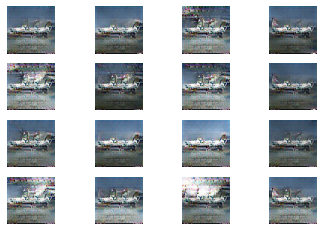

In [23]:
train_gan(g, d, gan, latent_dim)

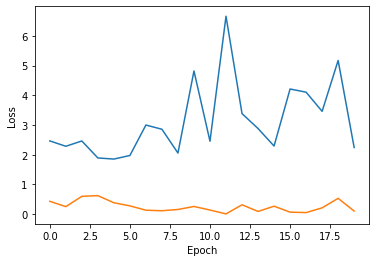

In [24]:
#Generator and Discriminator Losses
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

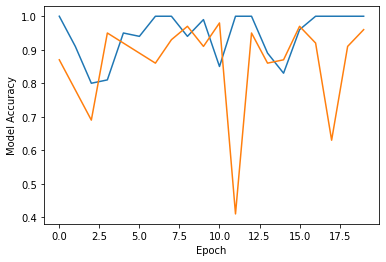

In [25]:
#Generator and Discriminator Accuracy
plt.plot(g_acc, label='Generator Accuracy')
plt.plot(d_acc, label='Discriminator Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Model Accuracy")

plt.show()

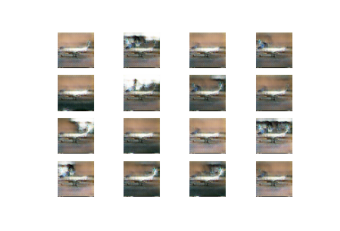

In [27]:
#Show sample images from final epoch
img = cv2.imread(f'images/epoch_20.png')
plt.imshow(img)
plt.axis('off')
plt.show()